In [ ]:
#hide
#colab
# attach gdrive holding repo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#default_exp multi_core.lr_find

# Multi Core LR Find XLA Extensions

> Classes to replace LRFinder and patches to Learner
to support running lr_find using multi core TPUs

Modifications to existing callback `LRFinder` are needed in order to run `lr_find` using multiple TPU cores. An equivalent `xla_lr_find` method is patched to `Learner` so it can run on multiple TPU cores.

In [ ]:
#hide
#colab
# !pip install -Uqq git+https://github.com/fastai/fastai.git 
!pip install -Uqq fastai --upgrade

     |████████████████████████████████| 194kB 6.7MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 


In [ ]:
#hide
#colab
!pip install -qqq nbdev

     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 


In [ ]:
#hide
#colab
# !pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions.git

In [ ]:
#hide
#colab
# !pip install -Uqq git+https://github.com/butchland/my_timesaver_utils.git

In [ ]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
#hide
#colab
# !pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
VERSION = "nightly"  #@param ["1.5", "1.7" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  39658      0 --:--:-- --:--:-- --:--:-- 39658
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
     |████████████████████████████████| 61kB 3.3MB/s 
Uninstalling torch-1.7.0+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.7.0+cu101
Uninstalling torchvision-0.8.1+cu101:
  Successfully uninstalled torchvision-0.8.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...
- [1 files][122.6 MiB/122.6 MiB]                                                
Operation completed over 1 objects/122.6 MiB.                                    
Copying gs://

In [ ]:
#hide
#colab
%cd /content
!ln -s /content/drive/MyDrive/fastai_xla_extensions fastai_xla_extensions

/content


In [ ]:
#hide
!pip freeze | grep torch
!pip freeze | grep fast
!pip freeze | grep timesaver
!pip freeze | grep nbdev

torch==1.9.0a0+958d9a8
torch-xla==1.9+7671584
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.9.0a0+fc33c46
fastai==2.2.7
fastcore==1.3.19
fastdtw==0.3.4
fastprogress==1.0.0
fastrelease==0.1.11
fastrlock==0.5
nbdev==1.1.13


In [ ]:
# hide
# start of kernel

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
#colab
%cd /content/fastai_xla_extensions

/content/drive/MyDrive/fastai_xla_extensions


In [ ]:
#exporti
from fastai_xla_extensions.utils import xla_imported
from fastai_xla_extensions.multi_core.base import *
from fastai_xla_extensions.multi_core.callback import *
from fastai_xla_extensions.multi_core.learner import *
from fastai_xla_extensions.misc_utils import *
from fastai_xla_extensions.core import *


In [ ]:
#hide
#colab
%cd /content

/content


In [ ]:
#exporti
try:
    import torch_xla
except:
    pass


In [ ]:
#exporti
if xla_imported():
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp

In [ ]:
#hide
#local
# fake out torch_xla modules if not running on xla supported envs
if not xla_imported():
    # replace torch xla modules with fake equivalents
    from types import SimpleNamespace
    torch_xla = SimpleNamespace (
    )
    from typing import Union,BinaryIO
    import os
    import pickle
    import torch.cuda

    def fake_opt_step(opt,barrier=False):
        opt.step()
        
    def fake_device(n=None, devkind=None):
        gpu_available = torch.cuda.is_available()
        if gpu_available:
            return torch.device(torch.cuda.current_device()) 
        return torch.device('cpu')

    def fake_save(obj, f: Union[str, os.PathLike, BinaryIO], 
                master_only=True, global_master=False): 
        return torch.save(obj,f,pickle_module=pickle, 
                        pickle_protocol=2, 
                        _use_new_zipfile_serialization=True)
    def fake_rate():
        return 230.20

    def fake_global_rate():
        return 830.10

    def fake_add(*args,**kwargs):
        pass

    def fake_RateTracker():
        return SimpleNamespace(
            rate = fake_rate,
            global_rate = fake_global_rate,
            add = fake_add
        )
    def fake_xrt_world_size():
        return 1
    def fake_get_ordinal():
        return 0
    xm = SimpleNamespace(
        optimizer_step = fake_opt_step,
        xla_device = fake_device,
        save = fake_save,
        RateTracker = fake_RateTracker,
        master_print = print,
        xrt_world_size = fake_xrt_world_size,
        get_ordinal = fake_get_ordinal
    )

    def fake_metrics_report():
        return "Fake Metrics Report \n\n\n\n"
    met = SimpleNamespace (
        metrics_report = fake_metrics_report
    )

    class FakeParallelLoader:
        def __init__(self, loader, *args):
            self.loader = loader
        def per_device_loader(self,device):
            return self.loader
        
    pl = SimpleNamespace(
        ParallelLoader = FakeParallelLoader
    )

    def fake_MpModelWrapper(o):
        return o

    def fake_run(f,*args, **kwargs):
            return f(*args,**kwargs)
        
    def fake_MpSerialExecutor():
        return SimpleNamespace(
            run = fake_run
        )
    def fake_spawn(f, args=None, nprocs=0, start_method=None):
        return f(0,*args)

    xmp = SimpleNamespace (
        MpModelWrapper = fake_MpModelWrapper,
        MpSerialExecutor = fake_MpSerialExecutor,
        spawn = fake_spawn
    )

    xu = SimpleNamespace (
    )


In [ ]:
#export

from fastai.callback.core import Callback
from fastai.learner import CancelValidException
class SkipValidationCallback(Callback):
    order,run_valid = -9, False
    # raise CancelValidException before XLATrainingCallback.before_validate
    # to prevent call to wrap_parallel_loader on before_validate
    def before_validate(self): 
        raise CancelValidException()

    def after_cancel_validate(self):
        xm.mark_step()


In [ ]:
#export

from fastai.callback.schedule import ParamScheduler, SchedExp

class XLALRFinder(ParamScheduler):
    "Training with exponentially growing learning rate"
    def __init__(self, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True):
        if is_listy(start_lr):
            self.scheds = {'lr': [SchedExp(s, e) for (s,e) in zip(start_lr,end_lr)]}
        else: self.scheds = {'lr': SchedExp(start_lr, end_lr)}
        self.num_it,self.stop_div = num_it,stop_div
        self.skip_batch = False
        


    def before_fit(self):
        super().before_fit()
        # no need to save orig weights 
        # since learner instances are transient on spawned procs
        # self.learn.save('_tmp')
        self.best_loss = float('inf')
        self.skip_batch = False

    def before_epoch(self):
        # dont report losses while running lrfind (override sync_recorder)
        if not xm.is_master_ordinal():
            return
        if hasattr(self.learn, 'sync_recorder'):
            self.learn.logger = noop
            self.learn.sync_recorder._sync_stats_log = noop

    def before_batch(self):
        if self.skip_batch:
            return
        self._update_val(self.train_iter/self.num_it)

    def after_batch(self):
        if self.skip_batch:
            return
        super().after_batch()
        smooth_loss = self.smooth_loss.item() # move xla tensor to cpu
        if smooth_loss < self.best_loss:
            self.best_loss = smooth_loss

        # handle continuation of batch iteration until all batches exhausted
        if smooth_loss > 4*self.best_loss and self.stop_div:
            # print(f'xla {xm.get_ordinal()}: stop stats collection due to loss')
            self.skip_batch = True
            self.copy_losses_and_lrs()
            return
            

        if self.train_iter >= self.num_it:
            # print(f'xla {xm.get_ordinal()}: stop stats collection due to num_iter')
            # return and stop updating losses
            self.skip_batch = True
            self.copy_losses_and_lrs()
            return

    def copy_losses_and_lrs(self):
        if xm.is_master_ordinal():     
            losses = [loss.item() for loss in self.recorder.losses]
            iters = self.recorder.iters[:]
            values = self.recorder.values[:]
        
            self.plot_data = {'lrs': self.recorder.lrs[:],
                              'losses': losses,
                              'iters': iters,
                              'values': values}
            if hasattr(self,'hps'):
                self.plot_data['hps']  = {**self.hps}

    def after_fit(self):
        super().after_fit()
        # no need to load old weights since these will be transient
        # self.learn.opt.zero_grad() #Need to zero the gradients of the model before detaching the optimizer for future fits
        # tmp_f = self.path/self.model_dir/'_tmp.pth'
        # if tmp_f.exists():
        #     self.learn.load('_tmp', with_opt=True)
        #     os.remove(tmp_f)
        if not self.skip_batch:
            self.copy_losses_and_lrs()
        if xm.is_master_ordinal():
            with open('_plt_loss.pkl','wb') as f:
                pickle.dump(self.plot_data,f)


In [ ]:
#export
from fastai.learner import Learner
from fastai.callback.schedule import SuggestedLRs
from fastcore.basics import patch
from fastai.torch_core import tensor
@patch
def get_suggested_lrs(self:Learner, num_it):
    'compute Suggested LRs'
    lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
    if len(losses) == 0: return
    lr_min = lrs[losses.argmin()].item()
    grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
    lr_steep = lrs[grads.argmin()].item()
    return SuggestedLRs(lr_min/10.,lr_steep)


In [ ]:
#hide_input
show_doc(Learner.get_suggested_lrs)

<h4 id="Learner.get_suggested_lrs" class="doc_header"><code>Learner.get_suggested_lrs</code><a href="__main__.py#L6" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.get_suggested_lrs</code>(**`num_it`**)

compute Suggested LRs

In [ ]:
#export
import pickle
from fastai.learner import Recorder
from fastcore.basics import patch   
@patch
def reload_lr_find_attrs(self:Recorder, fn='_plt_loss.pkl'):
    if isinstance(fn,str):
        fn = Path(fn)

    if not fn.is_file():
        return
       
    with open(fn,'rb') as f:
        d = pickle.load(f)
        self.lrs,self.losses = d['lrs'],d['losses']
        self.values, self.iters = d['values'], d['iters']
        if 'hps' in d:
            self.hps = d['hps']
    # delete file after
    if fn.is_file():
        fn.unlink()


In [ ]:
#export

def xla_run_lr_find(rank, learner_args, add_args, lr_find_args, ctrl_args):
    xm.rendezvous('start_xla_run_lr_find')
    # print(f'xla {rank} : start run lrfind')
    sync_valid = True
    learner = make_xla_child_learner(rank, sync_valid, learner_args, add_args, ctrl_args)

    num_it = lr_find_args['num_it']
    n_epoch = num_it//len(learner.dls.train) + 1
    learner.opt = None
    learner.create_opt()
    cb = XLALRFinder(**lr_find_args) 
 
    skip_valid_cb = SkipValidationCallback()
    
    with learner.no_logging(): 
        learner.fit(n_epoch, cbs=[cb, skip_valid_cb])
        


In [ ]:
#export

from pathlib import Path
from fastai.learner import Learner
from fastcore.basics import patch
from fastcore.meta import delegates

@patch
@delegates(Learner.lr_find)
def xla_lr_find(self:Learner, num_cores=8, start_method='fork', **kwargs):
    lr_find_args = {
        'start_lr': 1e-7,
        'end_lr': 10.,
        'num_it': 100,
        'stop_div': True
    }
    fn = Path('_plt_loss.pkl')
    if fn.is_file():
        fn.unlink()
    # remove show_plot and suggestions param
    show_plot = kwargs.pop('show_plot', True)
    suggestions = kwargs.pop('suggestions',True)
    # override default with kwargs
    lr_find_args = {**lr_find_args, **kwargs}    

    ctrl_args = self.pre_xla_fit()
    learner_args, add_args = self.pack_learner_args()
    xmp.spawn(xla_run_lr_find,
              args=(learner_args, add_args, lr_find_args, ctrl_args),
              nprocs=num_cores,
              start_method=start_method)
    self.post_xla_fit(ctrl_args)
    self.recorder.reload_lr_find_attrs()
    if show_plot:
        # show_loss()
        self.recorder.plot_lr_find()
    if suggestions:
        return self.get_suggested_lrs(lr_find_args['num_it'])

## Test out `xla_lr_find`

In [ ]:
#colab
from fastai.vision.all import *
# path = untar_data(URLs.MNIST_TINY)
path = untar_data(URLs.MNIST)

In [ ]:
#colab
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    # splitter=GrandparentSplitter(),
    splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [ ]:
#colab
# dls = data.dataloaders(path, bs=8)
dls = data.dataloaders(path, bs=64)

In [ ]:
#colab
learner = cnn_learner(dls, resnet18, metrics=accuracy, concat_pool=False)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#colab
learner.unfreeze()

start fit


CPU times: user 3.1 s, sys: 368 ms, total: 3.47 s
Wall time: 51.4 s


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0006918309954926372)

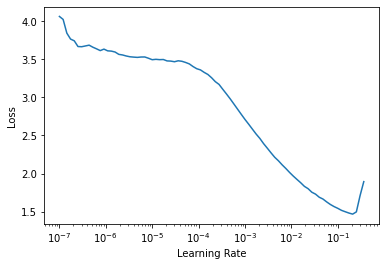

In [ ]:
#colab
%%time
learner.xla_lr_find()